In [69]:
import math, os
import numpy as np
import pickle
import pickle
from scipy import constants
from numba import jit
from astropy.io import fits
from scipy import interpolate
from POSEIDON.core import create_star, create_planet, define_model, make_atmosphere, read_opacities, wl_grid_constant_R, wl_grid_line_by_line, compute_spectrum
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocess import Pool # multiprocessing package somehow does not work with Jupyter notebook. See https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror
from time import time
from matplotlib.pyplot import *
import time
import pickle
from scipy import constants
import numpy as np
from matplotlib.pyplot import cm
from array import *
from scipy import signal
from scipy import special
from scipy import interp
from scipy import ndimage
from astropy.io import fits
import glob
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
import matplotlib.pyplot as plt

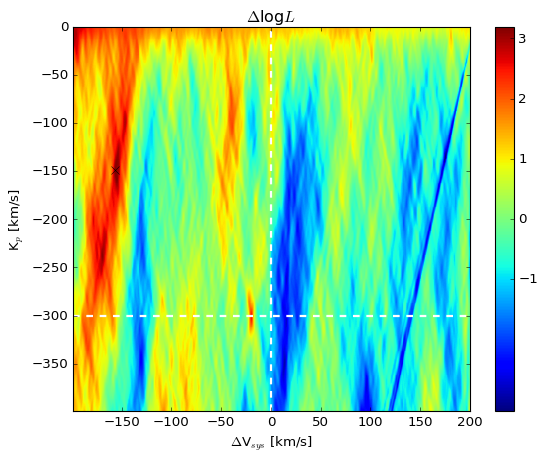

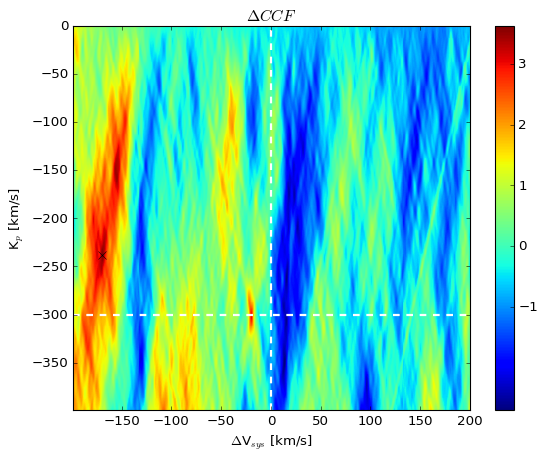

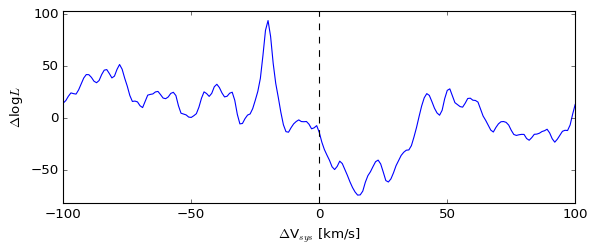

In [76]:
output_path = './CC_output/WASP-121b/'
name = 'BEST_FIT'
filearr = sorted(glob.glob(output_path+'test_sysrem_*.pic'))

Vsys = []
for i in range(len(filearr)):
	Vsysarr, Kparr, logLarr, CCF_arr = pickle.load(open(filearr[i],'rb'), encoding='latin1')
	Vsys = np.append(Vsys, Vsysarr)

logL = np.zeros((len(logLarr), len(Vsys)))
CCF = np.zeros((len(logLarr), len(Vsys)))

curr = 0
for i in range(len(filearr)):
	Vsysarr, Kparr, logLarr, CCF_arr = pickle.load(open(filearr[i],'rb'), encoding='latin1')
	logL[:, curr:curr+logLarr.shape[1]] = logLarr
	CCF[:, curr:curr+logLarr.shape[1]] = CCF_arr
	curr += logLarr.shape[1]

# xlimm=90
# ylimm=120
Vsysarr = Vsys
Kp = -300  #orbital velocity of planet

#logL
CCFarr1 = logL[::-1, :]
CCFarr1 = CCFarr1-np.mean(CCFarr1)
# stdev=np.std(CCFarr1[ylimm:-1,0:xlimm])
stdev=np.std(CCFarr1)
maxx = (CCFarr1/stdev).max()
loc = np.where(CCFarr1/stdev == maxx)
Vsysarr = Vsys
fig, ax = subplots()
cax = ax.imshow((CCFarr1)/stdev, extent = [Vsysarr.min(), Vsysarr.max(), Kparr.min(), Kparr.max()], aspect="auto", interpolation='none')
cbar = colorbar(cax,ticks=[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
axvline(x=0., color='white', ls='--', lw=2)
axhline(y=Kp, color='white', ls='--', lw=2)
plot(Vsysarr[loc[1]], Kparr[::-1][loc[0]], 'xk', ms=7)
axis([Vsysarr.min(), Vsysarr.max(), Kparr.min(), Kparr.max()])
xlabel('$\Delta$V$_{sys}$ [km/s]')
ylabel('K$_{p}$ [km/s]')
title('$\Delta $log$L$')


from datetime import datetime
now = datetime.now() # current date and time
date_time = now.strftime("%m_%d_%H_%M")

savefig(output_path+name+'_Kp_v_Vsys_LogL_SNR'+str(date_time)+'.pdf', fmt='pdf')
show()
close()


#CCF
CCFarr1 = CCF[::-1, :]
CCFarr1 = CCFarr1-np.mean(CCFarr1)
# stdev=np.std(CCFarr1[ylimm:-1,0:xlimm])
stdev=np.std(CCFarr1)
maxx = (CCFarr1/stdev).max()
loc = np.where(CCFarr1/stdev == maxx)
Vsysarr = Vsys
fig, ax = subplots()
cax = ax.imshow((CCFarr1)/stdev, extent = [Vsysarr.min(), Vsysarr.max(), Kparr.min(), Kparr.max()], aspect="auto", interpolation='none')
cbar = colorbar(cax,ticks=[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
axvline(x=0., color='white', ls='--', lw=2)
axhline(y=Kp, color='white', ls='--', lw=2)
plot(Vsysarr[loc[1]], Kparr[::-1][loc[0]], 'xk', ms=7)
axis([Vsysarr.min(), Vsysarr.max(), Kparr.min(), Kparr.max()])
xlabel('$\Delta$V$_{sys}$ [km/s]')
ylabel('K$_{p}$ [km/s]')
title('$\Delta CCF$')
savefig(output_path+name+'_Kp_v_Vsys_LogL_SNR'+str(date_time)+'.pdf', fmt='pdf')
show()
close()



# slice at Kp
slicee = CCFarr1[300]
plot(Vsysarr, slicee)
axis([-100, 100, 1.1*slicee.min(), 1.1*slicee.max()])
xlabel('$\Delta$V$_{sys}$ [km/s]')
ylabel('$\Delta$log$L$')
axvline(x = 0, ls='--', color='black')
subplots_adjust(left=0.1, right=0.9, top=0.7, bottom=0.3)
savefig(output_path+name+'_TOTAL_logL_SLICE.pdf', fmt='pdf')
show()
close()

In [12]:
import dill
data_dir = './reference_data/observations/WASP-121b'
pl_dat = dill.load(open('{}/planet_info_py3.dill'.format(data_dir),'rb'))
p_vel1 = pl_dat['p_vel1']   # planet velocity for transit 1 (transit 2 exists but is low quality)
tmodel1 = pl_dat['tmodel1'] # transit model, used for weighting
bv1 = pl_dat['bv1']         # barycentric correction
ph1 = pl_dat['ph1']         # orbital phase
bv1=bv1/1000
ph1=ph1
pickle.dump(bv1, open(data_dir+'/rvel.pic','wb'))  #the Vbary+Vsys now saved as one happy array pickle
pickle.dump(ph1, open(data_dir+'/ph.pic','wb'))  #the Vbary+Vsys now saved as one happy array pickle

In [6]:
a = CCFarr1-np.mean(CCFarr1)

In [7]:
a.shape

(200, 200)

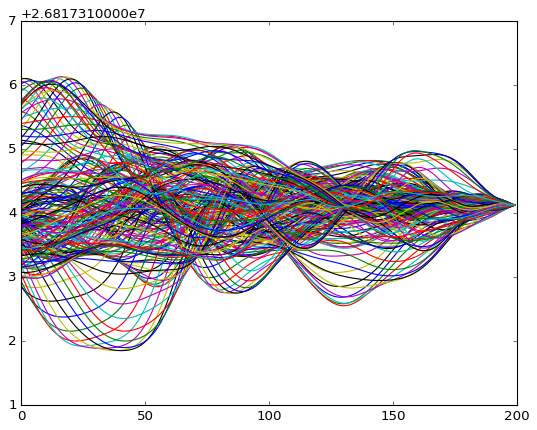

In [8]:
plt.plot(logL)

In [9]:
logL.std()

0.5355040066316852